## Ejercicio 2

Utilice para entrenamiento y prueba los conjuntos de datos `concent_trn.csv` y `concent_tst.csv`, que consisten en dos clases distribuidas en forma concéntrica como muestra la Figura 1. Determine la estructura de una red de tipo perceptrón multicapa que resulte más apropiada para resolver este problema. Represente gráficamente, con diferentes colores, el resultado de la clasificación realizada por el perceptrón multicapa.

### Entrenar


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PerceptronMulticapa

def cargarCSV(csvRelativePath, delimeter = ',') -> np.ndarray[any]:
    this_folder = os.path.abspath('') 
    fullPath = os.path.join(this_folder, csvRelativePath)
    return np.loadtxt(fullPath, dtype=float, delimiter=delimeter)

# ===== PARAMETROS =====
max_epocas = 5000
target_error = 0.01
cant_intentos = 5

# leer archivos
trnFileConcent = cargarCSV('./data/concent_trn.csv')
tstFileConcent = cargarCSV('./data/concent_tst.csv')

# ===== TRAINING =====
x = trnFileConcent[:,:-1]
yd = trnFileConcent[:,-1]

# Definir variantes de diseño
η = [0.1, 0.05, 0.01, 0.001]
neuronas = [[2,1], [3,1], [8,1], [2,2,1], [3,2,1], [16,8,1]]

redes: list[list[PerceptronMulticapa.PerceptronMulticapa]] = [[None for i in range(len(η))] for j in range(len(neuronas))]
trnErr: list[list[float]] = [[None for i in range(len(η))] for j in range(len(neuronas))]

# Entrenar todos los diseños
for j in range(len(neuronas)):
    for i in range(len(η)):
        # Entrenar 5 con el mismo diseño y quedarnos con la mejor
        candidatas: list[PerceptronMulticapa.PerceptronMulticapa] = [None for _ in range(cant_intentos)]
        err: list[float] = [None for _ in range(cant_intentos)]

        for intento in range(cant_intentos):
            # crear y entrenar NN
            candidatas[intento] = PerceptronMulticapa.PerceptronMulticapa(
                cant_entradas=x.shape[1],
                capas=neuronas[j],
                max_epocas=max_epocas,
                tasa_aprendizaje=η[i]
            )

            err[intento] = candidatas[intento].entrenarMinibatch(x, yd, targetError=0.01, batchSize=64)

        mejorIndex = np.argmin(err)
        redes[j][i] = candidatas[mejorIndex]
        trnErr[j][i] = err[mejorIndex]

### Error

In [2]:
# test
x_tst = tstFileConcent[:,:-1]
yd_tst = tstFileConcent[:,-1]
tstErr = [[redes[j][i].test(x_tst,yd_tst) for i in range(len(η))] for j in range(len(neuronas))]

from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Neuronas", "η", f"Training ({x.shape[0]} casos)", f"Testing ({x_tst.shape[0]} casos)"]

for j in range(len(neuronas)):
    str_neuronas = ""
    for n in neuronas[j]:
        str_neuronas += f"{n}, "
    for i in range(len(η)):
        table.add_row([str_neuronas, η[i], trnErr[j][i], tstErr[j][i]])

print(table)

+------------+-------+-----------------------+----------------------+
|  Neuronas  |   η   | Training (1499 casos) | Testing (1000 casos) |
+------------+-------+-----------------------+----------------------+
|   2, 1,    |  0.1  |  0.28218812541694466  |        0.303         |
|   2, 1,    |  0.05 |   0.3682454969979987  |        0.369         |
|   2, 1,    |  0.01 |   0.3682454969979987  |        0.369         |
|   2, 1,    | 0.001 |   0.3682454969979987  |        0.369         |
|   3, 1,    |  0.1  |  0.27084723148765844  |        0.297         |
|   3, 1,    |  0.05 |   0.2768512341561041  |        0.282         |
|   3, 1,    |  0.01 |   0.3682454969979987  |        0.369         |
|   3, 1,    | 0.001 |   0.3682454969979987  |        0.369         |
|   8, 1,    |  0.1  |  0.00867244829886591  |        0.014         |
|   8, 1,    |  0.05 |  0.009339559706470981 |        0.013         |
|   8, 1,    |  0.01 |   0.3682454969979987  |        0.369         |
|   8, 1,    | 0.001

### Gráficas

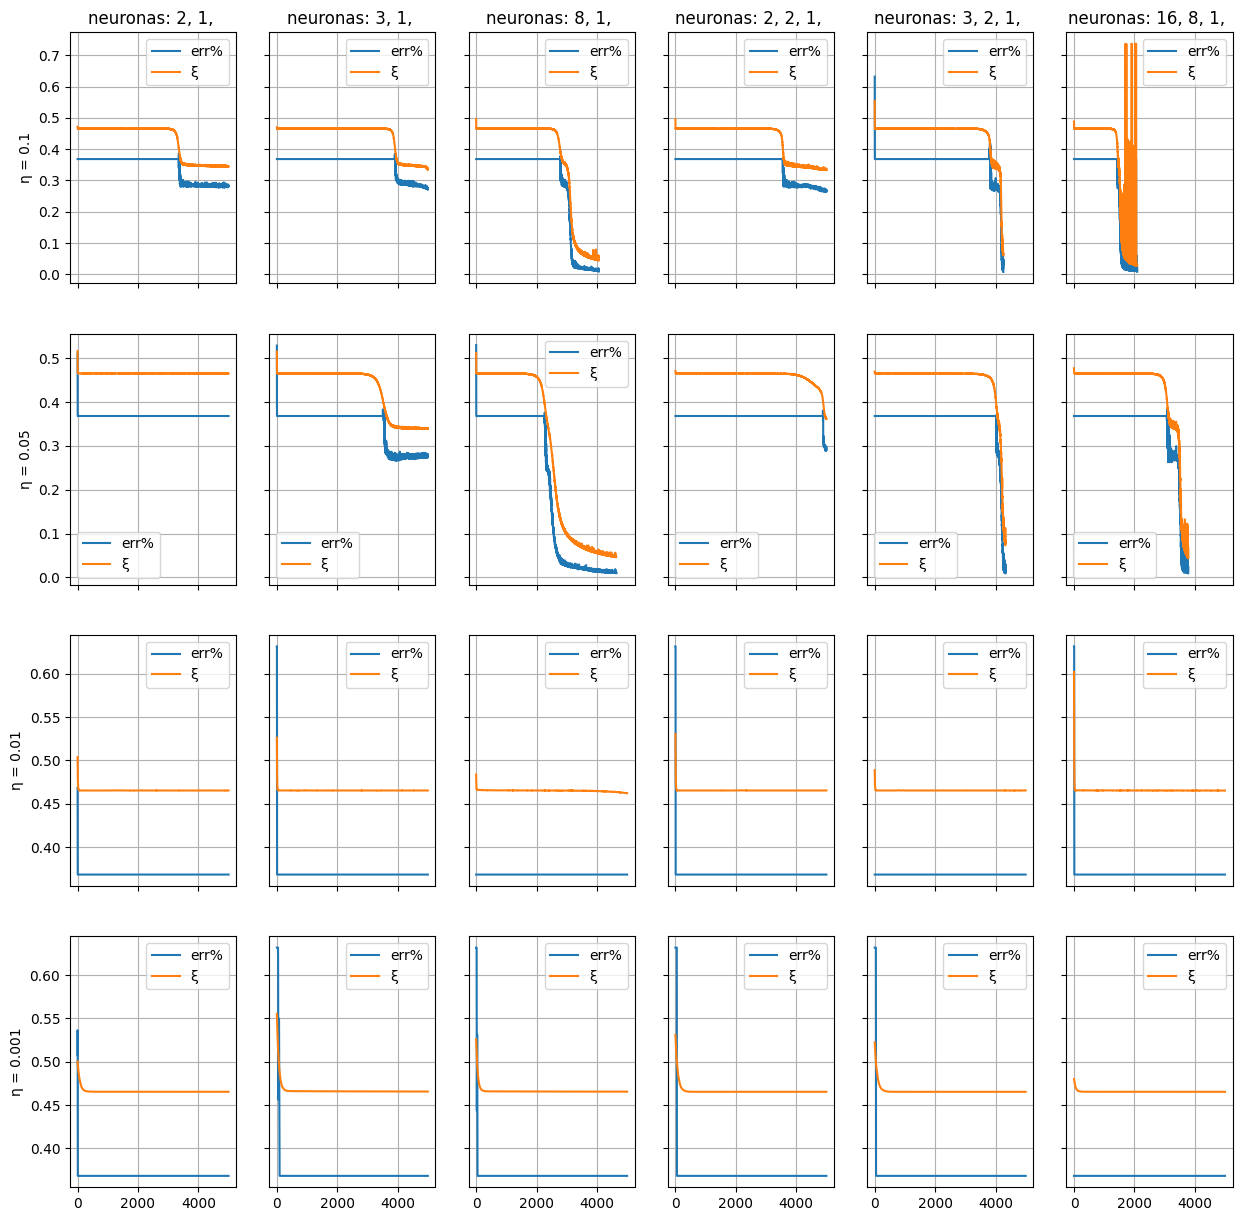

In [3]:
# Gráficas
fig, ax = plt.subplots(len(η), len(neuronas), sharex="col", sharey="row")
fig.set_figwidth(15)
fig.set_figheight(15)

# graficas de error
for j in range(len(neuronas)):
    label = "neuronas: "
    for n in neuronas[j]:
        label += f"{n}, "
    ax[0,j].set_title(label)
    for i in range(len(η)):
        if j == 0:
            ax[i,j].set_ylabel(f"η = {η[i]}")
        ax[i,j].grid()
        ax[i,j].plot(redes[j][i].error_history, label="err%")
        ax[i,j].plot(redes[j][i].quaderror_history, label="ξ")
        ax[i,j].legend()

plt.show()

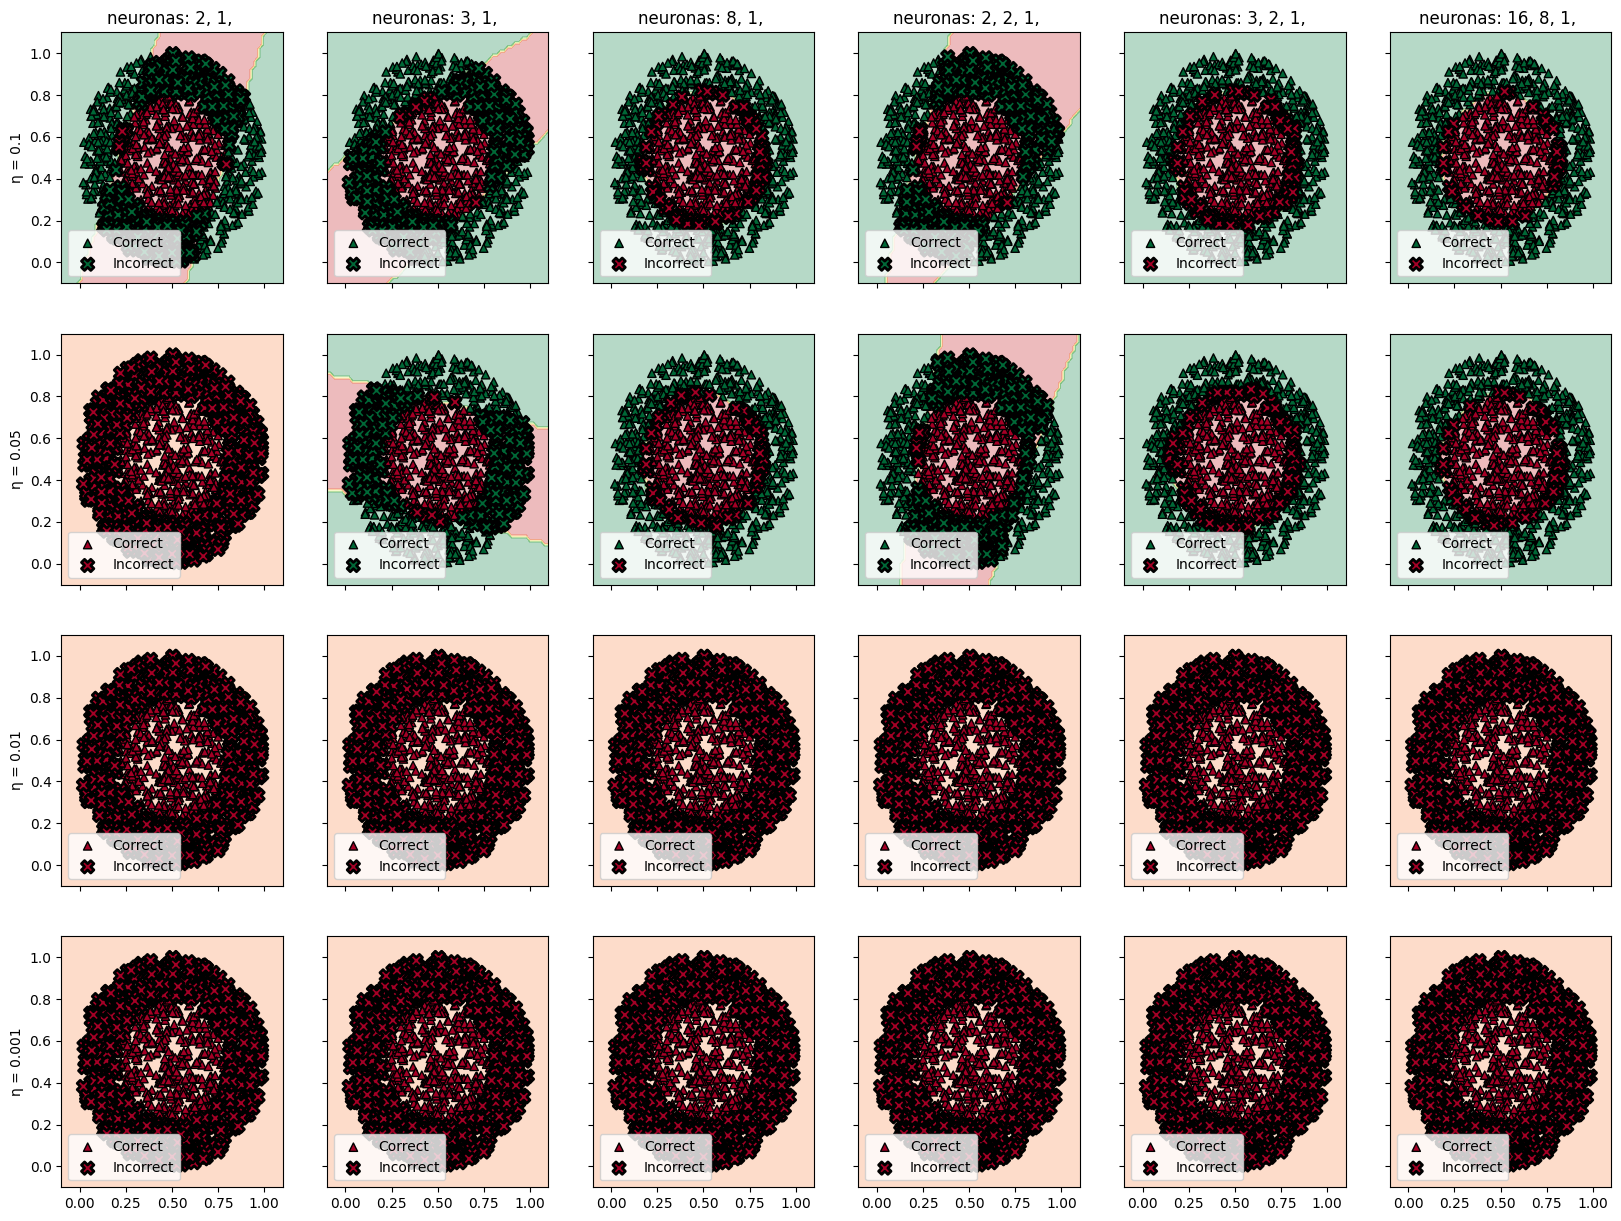

In [6]:
# ===== Regiones de decision =====
def plot_decision_region(red, x, yd, mesh, axi):
    (xx, yy) = mesh
    # calcular prediccion de la red en la malla
    Z = red.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.where(Z >= 0.5, 1, -1)   # binarize if needed
    Z = Z.reshape(xx.shape)

    # regiones
    axi.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlGn)

    # predictions on training set
    y_pred = red.predict(x)
    y_pred = np.where(y_pred >= 0.5, 1, -1)

    # correct vs incorrect
    correct_idx = (y_pred == yd)
    wrong_idx   = ~correct_idx

    # correct points → triangles
    axi.scatter(x[correct_idx,0], x[correct_idx,1], 
                c=yd[correct_idx], cmap=plt.cm.RdYlGn, 
                marker="^", edgecolor="k", label="Correct")

    # incorrect points → X
    axi.scatter(x[wrong_idx,0], x[wrong_idx,1], 
                c=yd[wrong_idx], cmap=plt.cm.RdYlGn, 
                marker="X", s=80, edgecolor="k", linewidth=2, 
                label="Incorrect")

    axi.legend()

# limites
x_min, x_max = -0.1, 1.1
y_min, y_max = -0.1, 1.1

# malla
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# graficar
fig, ax = plt.subplots(len(η), len(neuronas), sharex="col", sharey="row")
fig.set_figwidth(20)
fig.set_figheight(15)
for j in range(len(neuronas)):
    label = "neuronas: "
    for n in neuronas[j]:
        label += f"{n}, "
    ax[0,j].set_title(label)
    for i in range(len(η)):
        if j == 0:
            ax[i,j].set_ylabel(f"η = {η[i]}")
        plot_decision_region(redes[j][i], x_tst, yd_tst, mesh=(xx,yy), axi=ax[i,j])

Text(0.5, 1.0, 'neuronas: [16,8,1]; η: 0.1')

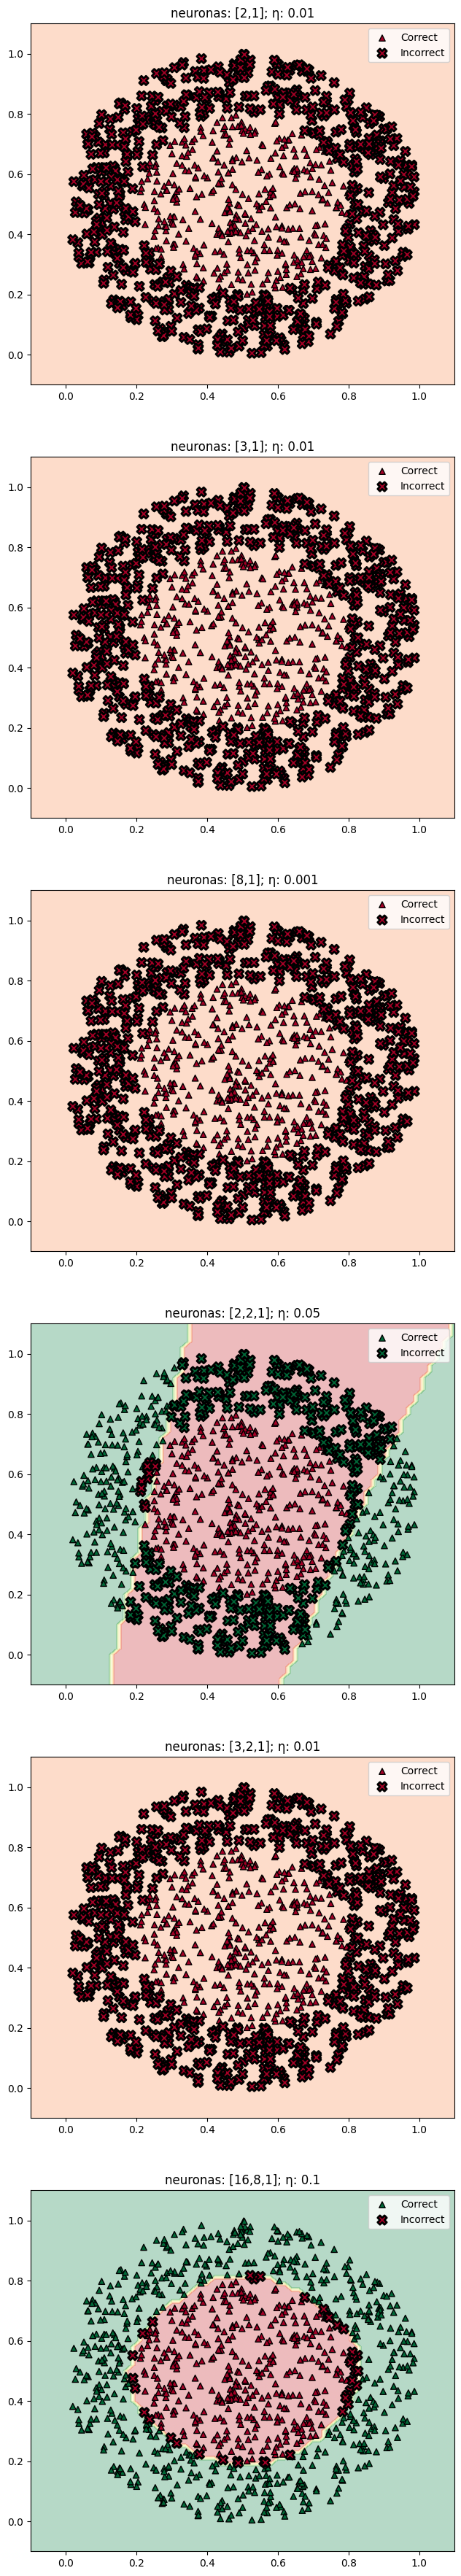

In [7]:
fig, ax = plt.subplots(6, 1)
fig.set_figheight(45)
fig.set_figwidth(7.5)
plot_decision_region(redes[0][2], x_tst, yd_tst, mesh=(xx,yy), axi=ax[0])
n = np.char.mod('%i', neuronas[0])
ax[0].set_title(f"neuronas: [{",".join(n)}]; η: {η[2]}")
plot_decision_region(redes[1][2], x_tst, yd_tst, mesh=(xx,yy), axi=ax[1])
n = np.char.mod('%i', neuronas[1])
ax[1].set_title(f"neuronas: [{",".join(n)}]; η: {η[2]}")
plot_decision_region(redes[2][3], x_tst, yd_tst, mesh=(xx,yy), axi=ax[2])
n = np.char.mod('%i', neuronas[2])
ax[2].set_title(f"neuronas: [{",".join(n)}]; η: {η[3]}")
plot_decision_region(redes[3][1], x_tst, yd_tst, mesh=(xx,yy), axi=ax[3])
n = np.char.mod('%i', neuronas[3])
ax[3].set_title(f"neuronas: [{",".join(n)}]; η: {η[1]}")
plot_decision_region(redes[4][2], x_tst, yd_tst, mesh=(xx,yy), axi=ax[4])
n = np.char.mod('%i', neuronas[4])
ax[4].set_title(f"neuronas: [{",".join(n)}]; η: {η[2]}")
plot_decision_region(redes[5][0], x_tst, yd_tst, mesh=(xx,yy), axi=ax[5])
n = np.char.mod('%i', neuronas[5])
ax[5].set_title(f"neuronas: [{",".join(n)}]; η: {η[0]}")